Importation des librairies

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,cross_val_predict,train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from joblib import dump
import seaborn as sns
import pandas as pd
import numpy as np
import time

Analyse de la distribution et des attributs

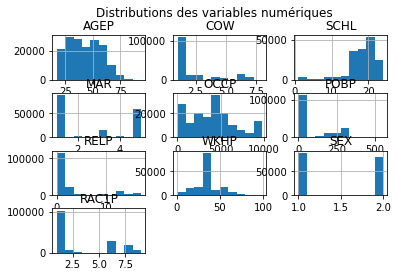

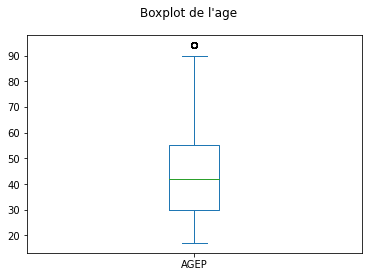

In [4]:
#Importation des dataset contenant les features et les labels
df = pd.read_csv('alt_acsincome_ca_features_85.csv')
df_label = pd.read_csv('alt_acsincome_ca_labels_85.csv')

df.hist()
plt.suptitle('Distributions des variables numériques')
plt.show()

df['AGEP'].plot(kind='box')
plt.suptitle("Boxplot de l'age")
plt.show()

Partition du jeu de données

In [45]:
X = df
y = df_label['PINCP'].astype(int)

#On fais des versions moins lourde pour accélérer l'apprentissage 
X_sampled = X.sample(frac=0.25,random_state=42)
y_sampled = y.sample(frac=0.25,random_state=42)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,train_size=0.8,random_state=42)
X_train_sp,X_test_sp,y_train_sp,y_test_sp = train_test_split(X_sampled,y_sampled,test_size=0.2,train_size=0.8,random_state=42)

Préparation des données

In [46]:
my_scaler = StandardScaler()
my_scaler_sp = StandardScaler()
X_scaled = my_scaler.fit_transform(X_train)
X_scaled_sp = my_scaler_sp.fit_transform(X_train_sp)

#On ne fit pas les données de tests
X_scaled_test = my_scaler.transform(X_test)
X_scaled_test_sp = my_scaler_sp.transform(X_test_sp)

#Sauvegarde de la standardisation effectuée
dump(my_scaler, 'scaler.joblib')

['scaler.joblib']

# Recherche de bons modèles #

### Random Forest 

In [16]:
#Choix du modèle
rf = RandomForestClassifier(random_state=42)

#Entrainement du modèle
start_time = time.time()
model = rf.fit(X_scaled,y_train)
#Utilisation d'une validation croisée pour la prédiction
y_pred = cross_val_predict(model, X_scaled_test, y_test, cv=5)
end_time = time.time()

In [17]:
#On print différentes valeurs nous donnant des informations sur la qualité de l'apprentissage
exec_time = end_time - start_time
print("Temps d'execution = ", exec_time,"secondes")
print("classification report :  \n", classification_report(y_test,y_pred))
print("accuracy score : ", accuracy_score(y_test,y_pred)*100,"%")
print("matrice de confusion : \n", confusion_matrix(y_test,y_pred))

Temps d'execution =  24.987541675567627 secondes
classification report :  
               precision    recall  f1-score   support

           0       0.83      0.85      0.84     19594
           1       0.77      0.75      0.76     13669

    accuracy                           0.81     33263
   macro avg       0.80      0.80      0.80     33263
weighted avg       0.81      0.81      0.81     33263

accuracy score :  80.80750383308781 %
matrice de confusion : 
 [[16612  2982]
 [ 3402 10267]]


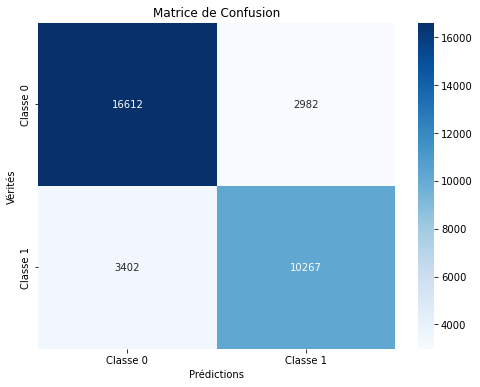

In [18]:
cm = confusion_matrix(y_test,y_pred)
classes = ['Classe 0', 'Classe 1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()

Random forest : amélioration du modèle

In [ ]:
#Initial parameters
param_grid = {
    'n_estimators':np.linspace(100,700,10),
    'max_depth':range(10,50),
    'min_samples_split':range(2,20)
}

grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(), cv=5, scoring='accuracy',param_distributions=param_grid,n_iter=20)
grid_search.fit(X_scaled_sp,y_train_sp)
print(f"Meilleurs hyperparametres: {grid_search.best_params_}")

meilleur_model = grid_search.best_estimator_

In [42]:
#Test sans sample pour étudier la performance
param_grid = {
    'n_estimators':[500],
    'max_depth':[40,45,50],
    'min_samples_split':[15,20,25,30]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), cv=5, scoring='accuracy',param_grid=param_grid)
grid_search.fit(X_scaled,y_train)
print(f"Meilleurs hyperparametres: {grid_search.best_params_}")

meilleur_model = grid_search.best_estimator_

Meilleurs hyperparametres: {'max_depth': 50, 'min_samples_split': 20, 'n_estimators': 500}


In [55]:
meilleur_model_rf = RandomForestClassifier(n_estimators=500,max_depth=50, min_samples_split=20,random_state=42)
y_pred = cross_val_predict(meilleur_model_rf, X_scaled_test, y_test, cv=5)

In [56]:
#On print différentes valeurs nous donnant des informations sur la qualité de l'apprentissage
print("classification report :  \n", classification_report(y_test,y_pred))
print("accuracy score : ", accuracy_score(y_test,y_pred)*100,"%")
print("matrice de confusion : \n", confusion_matrix(y_test,y_pred))

classification report :  
               precision    recall  f1-score   support

           0       0.83      0.86      0.85     19594
           1       0.79      0.76      0.77     13669

    accuracy                           0.82     33263
   macro avg       0.81      0.81      0.81     33263
weighted avg       0.81      0.82      0.81     33263

accuracy score :  81.52301355860865 %
matrice de confusion : 
 [[16765  2829]
 [ 3317 10352]]


In [57]:
#Sauvegarde du meilleur modèle
dump(meilleur_model_rf, 'RandomForest_BestModel_08152.joblib')

['RandomForest_BestModel_08152.joblib']

### GradientBoosting

In [60]:
#Choix du modèle
gb = GradientBoostingClassifier(random_state=42)

#Entrainement du modèle
start_time = time.time()
model = gb.fit(X_scaled,y_train)
#Utilisation d'une validation croisée pour la prédiction
y_pred = cross_val_predict(model, X_scaled_test, y_test, cv=5)
end_time = time.time()

In [61]:
#On print différentes valeurs nous donnant des informations sur la qualité de l'apprentissage
exec_time = end_time - start_time
print("Temps d'execution = ", exec_time,"secondes")
print("classification report :  \n", classification_report(y_test,y_pred))
print("accuracy score : ", accuracy_score(y_test,y_pred)*100,"%")
print("matrice de confusion : \n", confusion_matrix(y_test,y_pred))

Temps d'execution =  21.18802237510681 secondes
classification report :  
               precision    recall  f1-score   support

           0       0.84      0.85      0.84     19594
           1       0.78      0.76      0.77     13669

    accuracy                           0.81     33263
   macro avg       0.81      0.81      0.81     33263
weighted avg       0.81      0.81      0.81     33263

accuracy score :  81.39674713645792 %
matrice de confusion : 
 [[16647  2947]
 [ 3241 10428]]


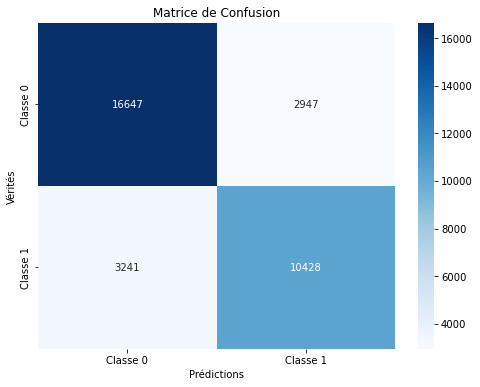

In [62]:
cm = confusion_matrix(y_test,y_pred)
classes = ['Classe 0', 'Classe 1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()

Gradient Boosting : amélioration du modèle

In [ ]:
param_grid = {
    'n_estimators':range(160,180),
    'learning_rate': np.linspace(0.4,0.8,100),
    'max_depth':[2],
    'min_samples_split':range(60,100),
    'subsample': np.linspace(0.7,0.9,100)
}

grid_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(), cv=5, scoring='accuracy',n_iter=20,param_distributions=param_grid)
grid_search.fit(X_scaled,y_train)
print(f"Meilleurs hyperparametres: {grid_search.best_params_}")

meilleur_model_gb = grid_search.best_estimator_

In [64]:
#Random search fais dans un autre fichier (long à réexecuter)

gb = GradientBoostingClassifier(n_estimators=173, subsample=0.85, min_samples_split=70, max_depth=2, learning_rate=0.5,random_state=42)
meilleur_model_gb = gb.fit(X_scaled,y_train)
y_pred = cross_val_predict(meilleur_model_gb, X_scaled_test, y_test, cv=5)

In [86]:
#On print différentes valeurs nous donnant des informations sur la qualité de l'apprentissage
print("classification report :  \n", classification_report(y_test,y_pred))
print("accuracy score : ", accuracy_score(y_test,y_pred)*100,"%")
print("matrice de confusion : \n", confusion_matrix(y_test,y_pred))

classification report :  
               precision    recall  f1-score   support

           0       0.84      0.85      0.85     19649
           1       0.78      0.77      0.78     13614

    accuracy                           0.82     33263
   macro avg       0.81      0.81      0.81     33263
weighted avg       0.82      0.82      0.82     33263

accuracy score :  81.92886991552174 %
matrice de confusion : 
 [[16730  2919]
 [ 3092 10522]]


In [65]:
#Sauvegarde du meilleur modèle
dump(meilleur_model_gb, 'GradientBoosting_BestModel_08192.joblib')

['GradientBoosting_BestModel_08192.joblib']

### AdaBoost 

In [67]:
#Choix du modèle
ada = AdaBoostClassifier(random_state=42)

#Entrainement du modèle
start_time = time.time()
model = ada.fit(X_scaled,y_train)
#Utilisation d'une validation croisée pour la prédiction
y_pred = cross_val_predict(model, X_scaled_test, y_test, cv=5)
end_time = time.time()

/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

In [68]:
#On print différentes valeurs nous donnant des informations sur la qualité de l'apprentissage
exec_time = end_time - start_time
print("Temps d'execution = ", exec_time,"secondes")
print("classification report :  \n", classification_report(y_test,y_pred))
print("accuracy score : ", accuracy_score(y_test,y_pred)*100,"%")
print("matrice de confusion : \n", confusion_matrix(y_test,y_pred))

Temps d'execution =  5.3440001010894775 secondes
classification report :  
               precision    recall  f1-score   support

           0       0.84      0.84      0.84     19594
           1       0.77      0.76      0.77     13669

    accuracy                           0.81     33263
   macro avg       0.80      0.80      0.80     33263
weighted avg       0.81      0.81      0.81     33263

accuracy score :  80.99990980969847 %
matrice de confusion : 
 [[16504  3090]
 [ 3230 10439]]


AdaBoost : amélioration du modèle

In [ ]:
param_grid = {
    'n_estimators':[500],
    'learning_rate':np.linspace(0.6,1,10)
}

#Utilisation d'un grid search pour trouver le meilleur learning_rate
grid_search = GridSearchCV(estimator=AdaBoostClassifier(), scoring='accuracy',param_grid=param_grid)
grid_search.fit(X_scaled_sp,y_train_sp)
print(f"Meilleurs hyperparametres: {grid_search.best_params_}")

meilleur_model_ada = grid_search.best_estimator_

In [71]:
#Grid search fais dans un autre fichier (long à réexecuter)

ada = AdaBoostClassifier(n_estimators=800,learning_rate=0.888,random_state=42)
meilleur_model_ada = ada.fit(X_scaled,y_train)
y_pred = cross_val_predict(meilleur_model_ada, X_scaled_test, y_test, cv=5)

/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

In [76]:
#On print différentes valeurs nous donnant des informations sur la qualité de l'apprentissage
print("classification report :  \n", classification_report(y_test,y_pred))
print("accuracy score : ", accuracy_score(y_test,y_pred)*100,"%")
print("matrice de confusion : \n", confusion_matrix(y_test,y_pred))

classification report :  
               precision    recall  f1-score   support

           0       0.84      0.85      0.85     19594
           1       0.78      0.77      0.78     13669

    accuracy                           0.82     33263
   macro avg       0.81      0.81      0.81     33263
weighted avg       0.82      0.82      0.82     33263

accuracy score :  81.81162252352465 %
matrice de confusion : 
 [[16637  2957]
 [ 3093 10576]]


In [73]:
#Sauvegarde du meilleur modèle
dump(meilleur_model_ada, 'AdaBoost_BestModel_08181.joblib')

['AdaBoost_BestModel_08181.joblib']

Inférence sur un autre jeu de donnée.

### Méthode de Stacking ###

In [ ]:
base_learners = [('ada', meilleur_model_ada),
                 ('rf', meilleur_model_rf)]  

meta_learner = meilleur_model_gb

stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
)

stacking_model.fit(X_scaled, y_train)

y_pred_stacking = stacking_model.predict(X_scaled_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
report_stacking = classification_report(y_test, y_pred_stacking)   
conf_matrix_stacking =  confusion_matrix(y_test, y_pred_stacking)


print(f"Accuracy of StackingClassifier : {accuracy_stacking}")
print("\nClassification Report of StackingClassifier")
print(report_stacking)
print("\nConfusion Matrix of StackingClassifier")
print(conf_matrix_stacking)

classes = ['Classe 0', 'Classe 1']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion pour StackingClassifier')
plt.show()

/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/revol/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warning

In [80]:
#Sauvegarde du meilleur modèle
dump(stacking_model, 'Stacking_BestModel_08220.joblib')

['Stacking_BestModel_08220.joblib']

### Test de nos modèles sur d'autres jeu de données ###

In [ ]:
#Importation des dataset contenant les features et les labels
df_co = pd.read_csv('acsincome_co_features.csv')
df_label_co = pd.read_csv('acsincome_co_labels.csv')

df_ne = pd.read_csv('acsincome_co_features.csv')
df_label_ne = pd.read_csv('acsincome_co_labels.csv')

X_co = df_co
y_co = df_label_co['PINCP'].astype(int)
X_ne = df_ne
y_ne = df_label_ne['PINCP'].astype(int)

y_pred = meilleur_model_rf.predict(X_co)
print("Prediction colorado pour random forest :")
print("classification report :  \n", classification_report(y_co,y_pred))
print("accuracy score : ", accuracy_score(y_co,y_pred)*100,"%")
y_pred = meilleur_model_gb.predict(X_co)
print("Prediction colorado pour GradientBoosting :")
print("classification report :  \n", classification_report(y_co,y_pred))
print("accuracy score : ", accuracy_score(y_co,y_pred)*100,"%")
y_pred = meilleur_model_ada.predict(X_co)
print("Prediction colorado pour AdaBoost :")
print("classification report :  \n", classification_report(y_co,y_pred))
print("accuracy score : ", accuracy_score(y_co,y_pred)*100,"%")

Pour le nevada

In [ ]:
y_pred = meilleur_model_rf.predict(X_ne)
print("Prediction colorado pour random forest :")
print("classification report :  \n", classification_report(y_ne,y_pred))
print("accuracy score : ", accuracy_score(y_ne,y_pred)*100,"%")
y_pred = meilleur_model_gb.predict(X_ne)
print("Prediction colorado pour GradientBoosting :")
print("classification report :  \n", classification_report(y_ne,y_pred))
print("accuracy score : ", accuracy_score(y_ne,y_pred)*100,"%")
y_pred = meilleur_model_ada.predict(X_ne)
print("Prediction colorado pour AdaBoost :")
print("classification report :  \n", classification_report(y_ne,y_pred))
print("accuracy score : ", accuracy_score(y_ne,y_pred)*100,"%")

# Interprétabilité

### Importance des features

Random Forest

In [94]:
importances = meilleur_model_rf.feature_importances_
perm_importance = permutation_importance(meilleur_model_rf,X_scaled,y_train,scoring="accuracy")
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

for idx in sorted_idx:
    print(f"Attribut : {X.columns[idx]}, Importance permutée : {perm_importance.importances_mean[idx]}")


  Feature  Importance
4    OCCP    0.259047
7    WKHP    0.171130
2    SCHL    0.166863
0    AGEP    0.133887
6    RELP    0.094604
5    POBP    0.065850
1     COW    0.032750
3     MAR    0.030285
8     SEX    0.023721
9   RAC1P    0.021863
Attribut : WKHP, Importance permutée : 0.10419986170820432
Attribut : OCCP, Importance permutée : 0.09758891260559781
Attribut : SCHL, Importance permutée : 0.08396416438685628
Attribut : AGEP, Importance permutée : 0.08014460511679648
Attribut : RELP, Importance permutée : 0.042880978865406004
Attribut : POBP, Importance permutée : 0.030896190962931815
Attribut : SEX, Importance permutée : 0.030099509966028348
Attribut : COW, Importance permutée : 0.022386736012987418
Attribut : MAR, Importance permutée : 0.02211165559330188
Attribut : RAC1P, Importance permutée : 0.015969696058683834


AdaBoost

In [95]:
importances = meilleur_model_ada.feature_importances_
perm_importance = permutation_importance(meilleur_model_ada,X_scaled,y_train,scoring="accuracy")
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

feature_importance_ada = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_ada = feature_importance_ada.sort_values(by='Importance', ascending=False)

print(feature_importance_ada)

for idx in sorted_idx:
    print(f"Attribut : {X.columns[idx]}, Importance permutée : {perm_importance.importances_mean[idx]}")

  Feature  Importance
4    OCCP     0.73125
7    WKHP     0.06125
0    AGEP     0.05500
5    POBP     0.04125
6    RELP     0.03375
2    SCHL     0.03000
1     COW     0.02000
9   RAC1P     0.01750
3     MAR     0.00500
8     SEX     0.00500
Attribut : WKHP, Importance permutée : 0.060137389892673546
Attribut : OCCP, Importance permutée : 0.05974957159606768
Attribut : SCHL, Importance permutée : 0.03944623154856748
Attribut : AGEP, Importance permutée : 0.030821032378318236
Attribut : RELP, Importance permutée : 0.01311667618675405
Attribut : SEX, Importance permutée : 0.006531281002916134
Attribut : POBP, Importance permutée : 0.004919880948801958
Attribut : COW, Importance permutée : 0.002974776779003685
Attribut : MAR, Importance permutée : 0.0008898776418242216
Attribut : RAC1P, Importance permutée : 0.0004840212849111625


GradientBoost

In [96]:
importances = meilleur_model_gb.feature_importances_
perm_importance = permutation_importance(meilleur_model_gb,X_scaled,y_train,scoring="accuracy")
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

feature_importance_gb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_gb = feature_importance_gb.sort_values(by='Importance', ascending=False)

print(feature_importance_gb)
for idx in sorted_idx:
    print(f"Attribut : {X.columns[idx]}, Importance permutée : {perm_importance.importances_mean[idx]}")

  Feature  Importance
4    OCCP    0.339805
7    WKHP    0.220053
2    SCHL    0.191986
0    AGEP    0.094063
6    RELP    0.093013
8     SEX    0.023875
5    POBP    0.020509
1     COW    0.008499
3     MAR    0.005686
9   RAC1P    0.002511
Attribut : OCCP, Importance permutée : 0.07273096233051737
Attribut : WKHP, Importance permutée : 0.06629889065929107
Attribut : AGEP, Importance permutée : 0.039386104680876596
Attribut : SCHL, Importance permutée : 0.03574692601388927
Attribut : RELP, Importance permutée : 0.012658208820611439
Attribut : SEX, Importance permutée : 0.006284760845383741
Attribut : COW, Importance permutée : 0.005205483570333369
Attribut : POBP, Importance permutée : 0.004998045876800017
Attribut : MAR, Importance permutée : 0.0012010341821242498
Attribut : RAC1P, Importance permutée : 0.0008387698042870096


### Corrélation entre les variables

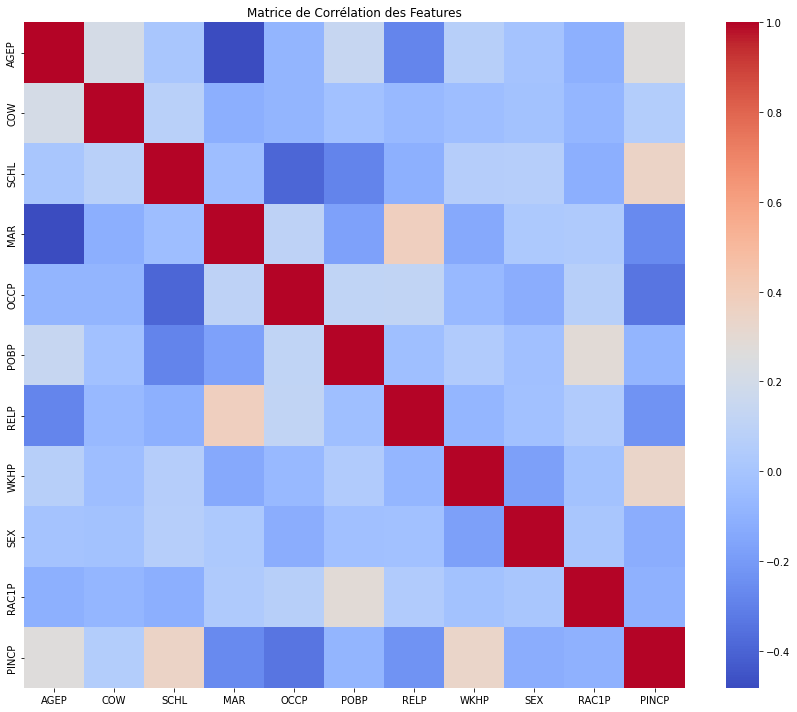

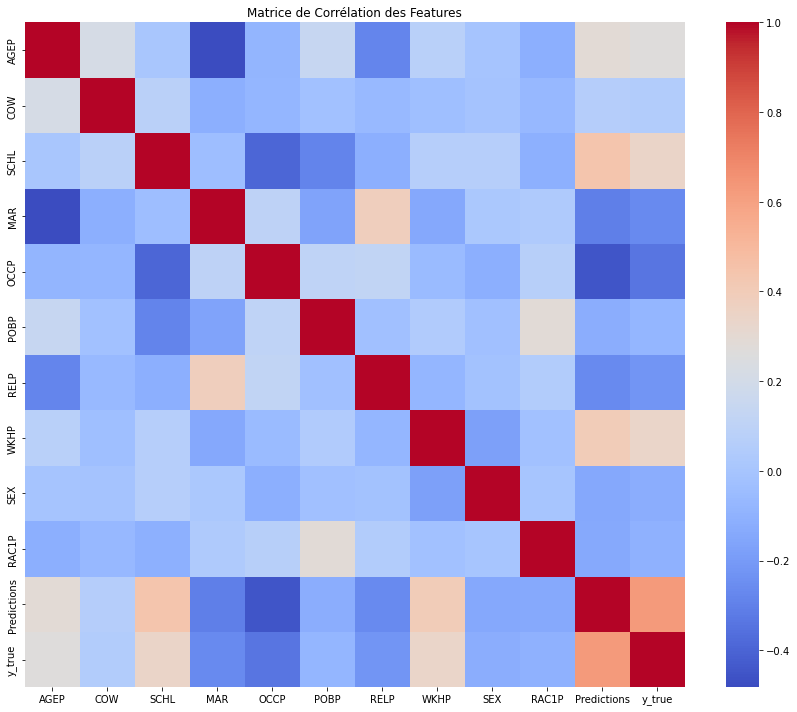

In [88]:
# --- Corrélation entre les features ---
correlation_matrix = pd.concat([X,y],axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title("Matrice de Corrélation des Features")
plt.tight_layout()
plt.show()

# Ajouter les prédictions au DataFrame original
X_test_df = pd.DataFrame(X_test, columns=X.columns)  # Convertir X_test en DataFrame avec noms des colonnes
X_test_df['Predictions'] = y_pred  # Ajouter les prédictions au DataFrame
X_test_df['y_true'] = y

# Calculer la nouvelle matrice de corrélation
correlation_matrix_with_preds = X_test_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_with_preds, annot=False, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title("Matrice de Corrélation des Features")
plt.tight_layout()
plt.show()

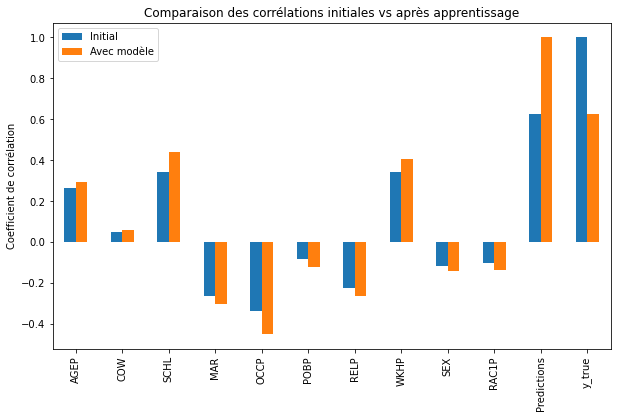

In [89]:
initial_corr = X_test_df.corr(method='pearson')['y_true']
pred_corr = X_test_df.corr(method='pearson')['Predictions']

comparison_df = pd.DataFrame({'Initial': initial_corr, 'Avec modèle': pred_corr})
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des corrélations initiales vs après apprentissage')
plt.ylabel('Coefficient de corrélation')
plt.show()

# Equité des modèles

Sur le dataset

In [ ]:
df_eval = df.loc()
df_eval['PINCP'] = df_label
print("Total length is : ",len(df_eval))
df_false = df_eval.loc[df_eval['PINCP']==False]  
print("Le taux d'individus ayant un nombre supérieur à 50000 est : ",((len(df_eval) - len(df_false))/len(df_eval))*100,"%")
print("Pour les femmes, le taux est ", ((df_eval[df_eval["SEX"] == 2].shape[0]- df_false[df_false["SEX"]==2].shape[0])/df_eval[df_eval["SEX"] == 2].shape[0])*100,"%")
print("Tandis que pour les hommes, le taux est ", ((df_eval[df_eval["SEX"] == 1].shape[0]- df_false[df_false["SEX"]==1].shape[0])/df_eval[df_eval["SEX"] == 1].shape[0])*100,"%")

Après application des modèles (fais avec GradientBoost)

In [43]:
y_pred = cross_val_predict(meilleur_model_gb, X_scaled_test, y_test, cv=5)

results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'SEX': X_test['SEX']  
})

# Calcul des métriques par genre
genres = results_df['SEX'].unique()
metrics = []

for genre in genres:
    subset = results_df[results_df['SEX'] == genre]
    
    # Matrice de confusion
    cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1])
    
    # Taux de prédictions positives (Statistical Parity)
    taux_positifs = (subset['y_pred'] == 1).mean()
    
    # Taux de vrais positifs (Equal Opportunity)
    vrais_positifs = ((subset['y_true'] == 1) & (subset['y_pred'] == 1)).sum()
    total_positifs = (subset['y_true'] == 1).sum()
    taux_vrais_positifs = vrais_positifs / total_positifs if total_positifs > 0 else 0
    
    # Taux de faux positifs (Predictive Equality)
    faux_positifs = ((subset['y_true'] == 0) & (subset['y_pred'] == 1)).sum()
    total_negatifs = (subset['y_true'] == 0).sum()
    taux_faux_positifs = faux_positifs / total_negatifs if total_negatifs > 0 else 0
    
    metrics.append({
        'Genre': 'Homme' if genre == 1 else 'Femme',
        'Statistical Parity': taux_positifs,
        'Equal Opportunity': taux_vrais_positifs,
        'Predictive Equality': taux_faux_positifs
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Genre  Statistical Parity  Equal Opportunity  Predictive Equality
0  Homme            0.471314           0.807815             0.179773
1  Femme            0.329995           0.726217             0.120367


### Suppression de la ligne "SEX"

In [45]:
y_ss = df_label['PINCP'].astype(int)
X_ss = df.drop('SEX',axis=1)

print(X_ss)

        AGEP  COW  SCHL  MAR    OCCP   POBP  RELP  WKHP  RAC1P
0       41.0  4.0  24.0  1.0  2555.0    6.0   1.0  60.0    1.0
1       77.0  7.0  22.0  1.0  4920.0   39.0   0.0  35.0    1.0
2       38.0  1.0  18.0  1.0   440.0    6.0   1.0  50.0    1.0
3       30.0  1.0  22.0  5.0  1555.0    6.0   2.0  80.0    6.0
4       36.0  1.0  16.0  1.0  4030.0  314.0   1.0  70.0    1.0
...      ...  ...   ...  ...     ...    ...   ...   ...    ...
166310  25.0  1.0  20.0  1.0  4720.0    6.0   7.0   8.0    1.0
166311  34.0  1.0  22.0  1.0   110.0  210.0   0.0  40.0    6.0
166312  54.0  3.0  18.0  1.0  7700.0    6.0   1.0  50.0    1.0
166313  39.0  1.0  16.0  5.0  9130.0    6.0   0.0  50.0    1.0
166314  32.0  1.0   9.0  5.0  4020.0  303.0   0.0  40.0    8.0

[166315 rows x 9 columns]


In [46]:
X_train_ss,X_test_ss,y_train_ss,y_test_ss = train_test_split(X,y,test_size=0.2,train_size=0.8)

my_scaler_ss = StandardScaler()
X_scaled_ss = my_scaler_ss.fit_transform(X_train_ss)
X_scaled_test_ss = my_scaler_ss.transform(X_test_ss)

gb = GradientBoostingClassifier(n_estimators=173, subsample=0.85, min_samples_split=70, max_depth=2, learning_rate=0.5)

model = gb.fit(X_scaled_ss,y_train_ss)
y_pred = cross_val_predict(model, X_scaled_test_ss, y_test_ss, cv=5)
print("classification report : ", classification_report(y_test_ss,y_pred))
print("accuracy score : ", accuracy_score(y_test_ss,y_pred))
print("matrice de confusion : ", confusion_matrix(y_test_ss,y_pred))

classification report :                precision    recall  f1-score   support

           0       0.84      0.85      0.84     19624
           1       0.78      0.77      0.77     13639

    accuracy                           0.82     33263
   macro avg       0.81      0.81      0.81     33263
weighted avg       0.82      0.82      0.82     33263

accuracy score :  0.815620960226077
matrice de confusion :  [[16660  2964]
 [ 3169 10470]]


In [47]:
X_test_with_sex = df.loc[X_test_ss.index]  
X_test_with_sex['SEX'] = df['SEX']
X_test_ss=X_test_with_sex

In [48]:
import seaborn as sns


results_df = pd.DataFrame({
    'y_true': y_test_ss,
    'y_pred': y_pred,
    'SEX': X_test_ss['SEX'] 
})


from sklearn.metrics import confusion_matrix

# Calcul des métriques par genre
genres = results_df['SEX'].unique()
metrics = []

for genre in genres:
    subset = results_df[results_df['SEX'] == genre]
    
    # Matrice de confusion
    cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1])
    
    # Taux de prédictions positives (Statistical Parity)
    taux_positifs = (subset['y_pred'] == 1).mean()
    
    # Taux de vrais positifs (Equal Opportunity)
    vrais_positifs = ((subset['y_true'] == 1) & (subset['y_pred'] == 1)).sum()
    total_positifs = (subset['y_true'] == 1).sum()
    taux_vrais_positifs = vrais_positifs / total_positifs if total_positifs > 0 else 0
    
    # Taux de faux positifs (Predictive Equality)
    faux_positifs = ((subset['y_true'] == 0) & (subset['y_pred'] == 1)).sum()
    total_negatifs = (subset['y_true'] == 0).sum()
    taux_faux_positifs = faux_positifs / total_negatifs if total_negatifs > 0 else 0
    
    metrics.append({
        'Genre': 'Homme' if genre == 1 else 'Femme',
        'Statistical Parity': taux_positifs,
        'Equal Opportunity': taux_vrais_positifs,
        'Predictive Equality': taux_faux_positifs
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df)




   Genre  Statistical Parity  Equal Opportunity  Predictive Equality
0  Homme            0.444211           0.777023             0.161097
1  Femme            0.358485           0.753968             0.141571
